# Feature Selection

We use feature selection to select features that are useful to the model. Irrelevant features may have a negative effect on a model. Correlated features can make coefficients in regression unstable or difficult to interpret. 

The *curse of dimensionality* is another issue to consider. As you increase the number of dimensions of your data, it becomes more sparse. This can make it difficult to pull out a signal unless you have more data. 

Training time is usually a function of the number of columns. If you can be concise and precise with your columns, you can have a better model in less time. 

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute, preprocessing
import warnings
warnings.filterwarnings("ignore")
url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
orig_df = df
cabin = df["cabin"]

In [28]:
def tweak_titanic(df):
    df = df.drop(
        columns = [
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.3,
    random_state = 42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.fit_transform(X_test[num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:,std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:,std_cols] = std.fit_transform(X_test[std_cols])
   
    return X_train, X_test, y_train, y_test

In [29]:
df = tweak_titanic(df)

In [33]:
X_train, X_test, y_train, y_test = get_train_test_X_y(df, "survived")

In [39]:
for k in data:
    path = f'data/titanic_{k}.csv'
    data[k].to_csv(path, header=True, index=False)
    #print(path)

In [15]:
# Refactors this section later
### START
df["cabin"] = cabin 

In [16]:
agg = df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index()

In [17]:
agg.columns = ["_".join(c).strip("_") for c in agg.columns.values]

In [18]:
agg_df = df.merge(agg, on="cabin") 
### END

In [19]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, 
                                                      "survived",
                                                      std_cols=std_cols)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Collinear Columns

Find Correlated features:

In [20]:
correlated_features = df[df.corr() >= .95].columns

In [21]:
correlated_features.tolist()

['pclass',
 'survived',
 'age',
 'sibsp',
 'parch',
 'fare',
 'sex_male',
 'embarked_Q',
 'embarked_S',
 'cabin']

The `rfpimp` packages has a visualization for *multicolliniearity*. The `plot_dependence_heatmap` function trains a random forest for each numeric column from the other columns in a training dataset. The dependence value is the R2 score from the out-of-bag estimates for predicting that column. 

The suggested way to use this plot is to find values close to 1. The label on the X axis is a features that predicts the Y axis label. If a feature predicts another, you can remove the predicted feature.

In [22]:
#!pip install rfpimp

In [23]:
import rfpimp
import matplotlib.pyplot as plt
%matplotlib inline

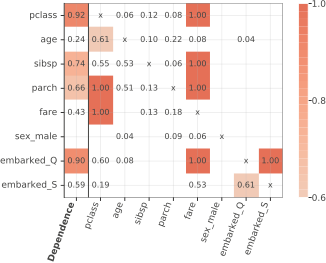

In [24]:
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train)
)

In our example, fare predicts pclass, sibsp, parch, and embarked_Q. We should be able to keep fare and remove the others and get similar performace:

# Lasso Regression

If you use lasso regression, you can set an `alpha` parameter that acts as a regularization parameter. As you increase the value, it gives less weight to features that are less important. Here use the `LassoLarsCV` model to iterate over various values of alpha and track the feature coefficients:

In [25]:
from sklearn.linear_model import LassoLarsCV

In [26]:
model = LassoLarsCV(cv=10, max_n_alphas=10)

In [27]:
model.fit(X_train, y_train)

LassoLarsCV(copy_X=True, cv=10, eps=2.220446049250313e-16, fit_intercept=True,
            max_iter=500, max_n_alphas=10, n_jobs=None, normalize=True,
            positive=False, precompute='auto', verbose=False)

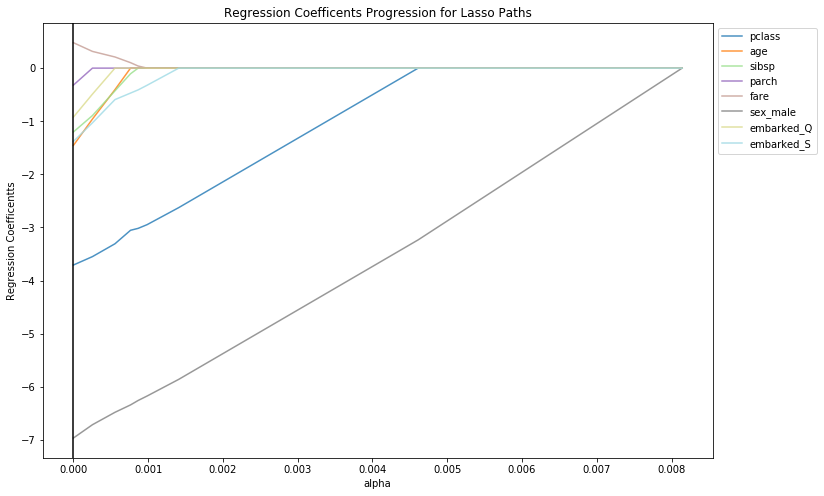

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
cm = iter(plt.get_cmap("tab20")(np.linspace(0,1,X.shape[1])))
for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(model.alphas_, model.coef_path_.T[:, i],c=c, alpha=0.8, label=X.columns[i])

ax.axvline(model.alpha_, linestyle="-",c="k",label="alphaCV")
plt.ylabel("Regression Coefficentts")
ax.legend(X.columns, bbox_to_anchor=(1,1))
plt.xlabel("alpha")
plt.title("Regression Coefficents Progression for Lasso Paths");

## Recursive Feature Elimination

Recursive feature elimination will remove the weakest features, then fit a model. It does this by passing in a scikit-learn model with a `.coef_` or `.feature_importances_` attribute:

In [31]:
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestClassifier

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


[1 1 2 3 1 1 5 4]
4
[ True  True False False  True  True False False]


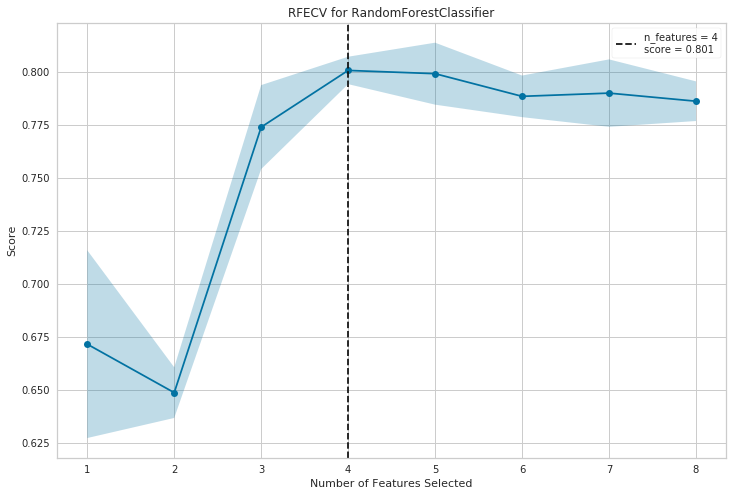

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
rfe = RFECV(RandomForestClassifier(n_estimators=100), cv=5)
rfe.fit(X,y)
print(rfe.rfe_estimator_.ranking_)
print(rfe.rfe_estimator_.n_features_)
print(rfe.rfe_estimator_.support_)
rfe.poof();

We will use recursive feature elimination to find the 10 most important features. In this aggregated dataset we find that we have leaked the survival column.

In [33]:
from sklearn.feature_selection import RFE
model = RandomForestClassifier(n_estimators=100)
rfe = RFE(model, 4)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

## Mutual Information

Sklearn provides nonparametric tests that will use k-nearest neighbor to determine the *mutual information* between features and the target. Mutual information quantifies the amount of information gained by observing another variable. The value is zero or more. If the value is zero, then there is no relation between them. This number is not bounded and represents the number of *bits* shared between the feature and the target. 

In [53]:
from sklearn.feature_selection import mutual_info_classif

In [54]:
mic = mutual_info_classif(X, y)

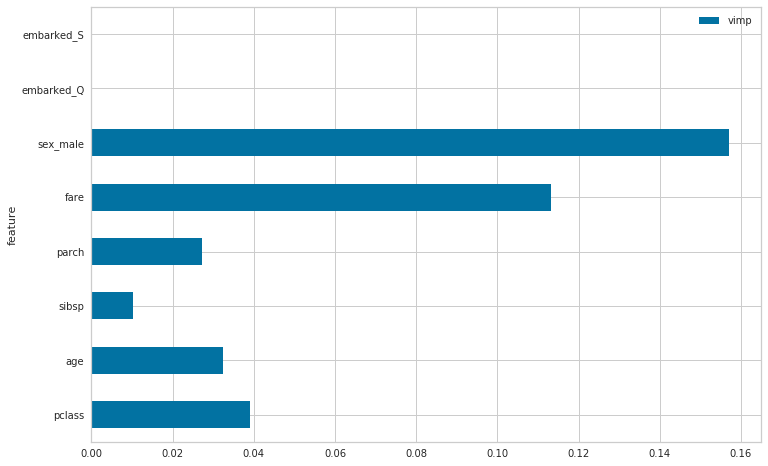

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame(dict(
    feature = X.columns, vimp = mic
)).set_index("feature").plot(kind="barh", ax=ax);

## Principal Component Analysis

Another option for feature selection is to run principal component analysis. Once you have the main principal components, examine the features that contribute to them the most. These are features taht have more variabce. Note that this is an unsupervised algorithm that DOES NOT take into account y. 

## Feature Importance

Most tree models provide access to a `.feature_importances_` attribute following training. A higher importance typically means that there is higher error when the feature is removed from the model. (We will cover the various tree models in detail later)